In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scripts.utils import fill_infos

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

np.random.seed(294697)

In [47]:
chunk_size = 100000
sample_size_percent = 5

data = pd.DataFrame()

for chunk in pd.read_csv("./datas/en.openfoodfacts.org.products.csv", sep="\t", nrows=None, chunksize=chunk_size):
    actual_chunk_size = chunk.shape[0]
    random_size = int(actual_chunk_size * (sample_size_percent / 100))
    random_indexes = np.random.default_rng().choice(chunk.index, size=random_size, replace=False)
    chunk = chunk.loc[random_indexes]
    data = pd.concat([data, chunk])
    del chunk

data.shape

/opt/anaconda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0,13,27,28,29,31,52) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/opt/anaconda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0,13,29,31,52) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/opt/anaconda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0,13,64) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/opt/anaconda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0,8,13,52,55,64) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_as

(95365, 186)

In [48]:
rows_nb, cols_nb = data.shape

In [49]:
data.head(1)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,quantity,packaging,packaging_tags,packaging_text,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,origins_en,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,allergens_en,traces,traces_tags,traces_en,serving_size,serving_quantity,no_nutriments,additives_n,additives,additives_tags,additives_en,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,nutriscore_score,nutriscore_grade,nova_group,pnns_groups_1,pnns_groups_2,states,states_tags,states_en,brand_owner,ecoscore_score_fr,ecoscore_grade_fr,main_category,main_category_en,image_url,image_small_url,image_ingredients_url,image_ingredients_small_url,image_nutrition_url,image_nutrition_small_url,energy-kj_100g,energy-kcal_100g,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,-palmitic-acid_100g,-stearic-acid_100g,-arachidic-acid_100g,-behenic-acid_100g,-lignoceric-acid_100g,-cerotic-acid_100g,-montanic-acid_100g,-melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,-alpha-linolenic-acid_100g,-eicosapentaenoic-acid_100g,-docosahexaenoic-acid_100g,omega-6-fat_100g,-linoleic-acid_100g,-arachidonic-acid_100g,-gamma-linolenic-acid_100g,-dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,-oleic-acid_100g,-elaidic-acid_100g,-gondoic-acid_100g,-mead-acid_100g,-erucic-acid_100g,-nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,-sucrose_100g,-glucose_100g,-fructose_100g,-lactose_100g,-maltose_100g,-maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,-soluble-fiber_100g,-insoluble-fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
48823,23923330023,http://world-en.openfoodfacts.org/product/0023...,usda-ndb-import,1489061518,2017-03-09T12:11:58Z,1581989632,2020-02-18T01:33:52Z,Baby food puree,NaN,NaN,NaN,NaN,NaN,NaN,Earth's Best,earth-s-best,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:no-artificial-flavors,en:no-artificial-flavors,No artificial flavors,NaN,NaN,NaN,NaN,NaN,NaN,NaN,United States,en:united-states,United States,"Organic apples, organic sweet potatoes, water,...",NaN,NaN,NaN,NaN,NaN,113 g (113 g),113.0,NaN,2.0,NaN,"en:e306,en:e330","E306 - Tocopherol-rich extract,E330 - Citric acid",0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,unknown,unknown,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://images.openfoodfacts.org/images/produc...,https://images.

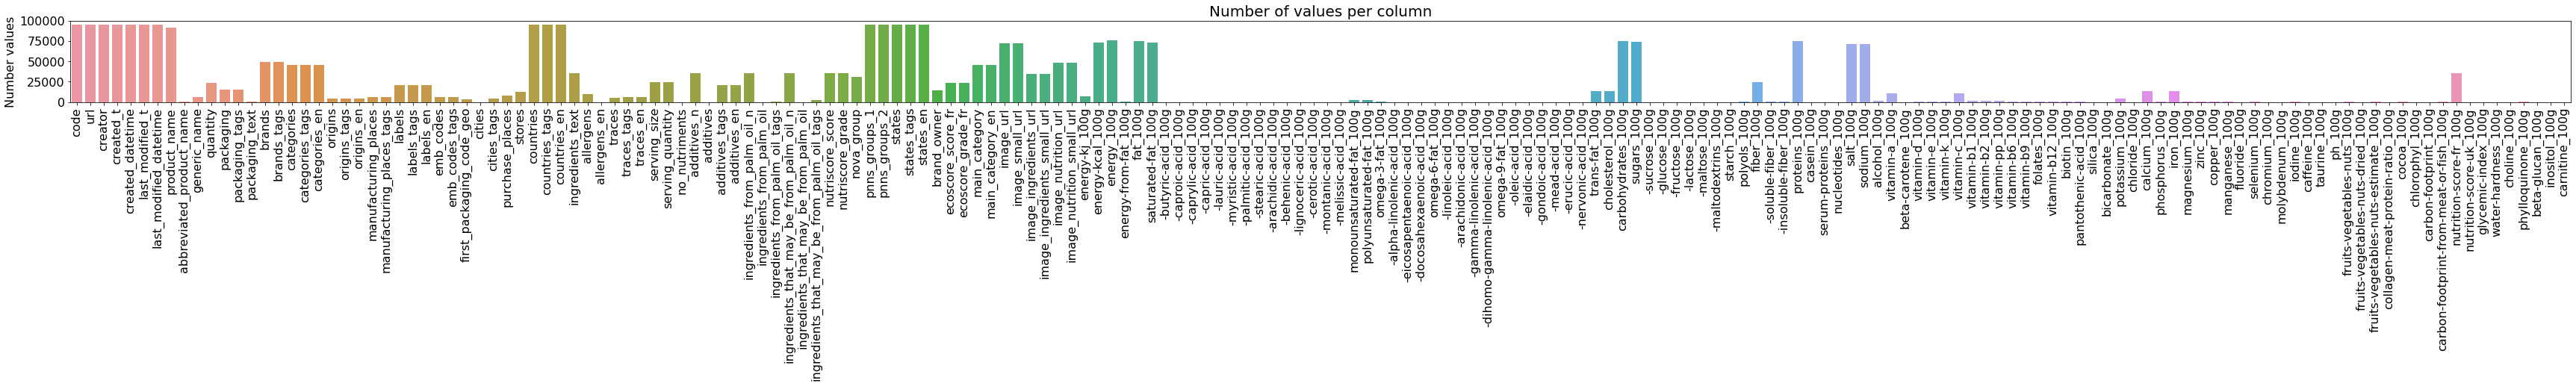

In [50]:
plt.figure(figsize=(60,2))

barplot = sns.barplot(x=data.columns, y=data.apply(lambda row: row.count(), axis=0))

plt.title("Number of values per column", size=20)
plt.xticks(rotation=90, size=16)
plt.yticks(size=16)
plt.ylabel("Number values", size=16)
plt.show()

Nutriscore is not quite well recorded.
Is there a way to calculate it from the others information ?

For that, we need to have the P and N ingredients of the nutriscore formula.

P (positive) ingredients:
- fruits, vegetable, nuts
- proteins
- fiber

N (negative) ingredients:
- sugar
- salt
- saturated fatty acid
- energey (kcal)

In [51]:
results = []
for ingredient in ["fruit", "vegetable", "nuts", "protein", "fiber", "sugar", "salt", "saturated-fat", "energy-kcal"]:
    for column in data.columns:
        if ingredient in column:
            results.append(column)
print(len(results))
results

21


['fruits-vegetables-nuts_100g',
 'fruits-vegetables-nuts-dried_100g',
 'fruits-vegetables-nuts-estimate_100g',
 'fruits-vegetables-nuts_100g',
 'fruits-vegetables-nuts-dried_100g',
 'fruits-vegetables-nuts-estimate_100g',
 'fruits-vegetables-nuts_100g',
 'fruits-vegetables-nuts-dried_100g',
 'fruits-vegetables-nuts-estimate_100g',
 'proteins_100g',
 'serum-proteins_100g',
 'collagen-meat-protein-ratio_100g',
 'fiber_100g',
 '-soluble-fiber_100g',
 '-insoluble-fiber_100g',
 'sugars_100g',
 'salt_100g',
 'saturated-fat_100g',
 'monounsaturated-fat_100g',
 'polyunsaturated-fat_100g',
 'energy-kcal_100g']

There are the fields needed for the nutriscore formulas, but:
- "fruits-vegetables-nuts_100g": maybe completement empty
- "fiber": maybe too fews records

In [52]:
nutriscore_features = [
    "fruits-vegetables-nuts_100g",
    "proteins_100g",
    "fiber_100g",
    "sugars_100g",
    "salt_100g",
    "saturated-fat_100g",
    "energy-kcal_100g"
]

***

In [53]:
features = [
    "code",
    "url",
    "product_name",
    "abbreviated_product_name",
    "generic_name",
    "brands",
    "brands_tags",
    "origins",
    "origins_tags",
    "origins_en",
    "manufacturing_places",
    "manufacturing_places_tags",
    "cities",
    "cities_tags",
    "purchase_places",
    "countries",
    "countries_tags",
    "countries_en",
    "nutriscore_score",
    "nutriscore_grade",
    "brand_owner",
    "ecoscore_score_fr",
    "ecoscore_grade_fr",
    "image_url",
    "image_small_url",
    ]

In [54]:
some = data.loc[:, features]